# Reconstructing MNIST digits: a simple application of variational autoencoders

Autoencoders are a type of neural network structure that take in inputs, compresses them to a lower dimensional representation, and uncompresses them to recreate the original input. This is the "auto" component of the autoencoder, where the neural network learns how to reconstruct the same input while finding a lower-dimensional representation of it. Because of these features, autoencoders are widely applied to data compression, dimensionality reduction, and denoising. They are unsupervised, since the labels, or the expected output, is the input itself.

![autoencoder](ae.png)

Here, we will build a simple autoencoder in Keras to reconstruct 2D images of handwritten digits in the MNIST dataset. This has no inherent practical use, but this will serve as an exercise of applying autoencoders. This notebook follows the Keras tutorial found at https://blog.keras.io/building-autoencoders-in-keras.html.

#### Setup

In [6]:
from keras.layers import Input,Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images between 0 and 1, flatten
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


#### Construct model

In [4]:
# Size of our encoded representations
latent_dim = 32

# Placeholder for an input image, flattened
input_img = Input(shape = (784,))
# Pass through encoder, which is a fully connected layer
encoded = Dense(latent_dim, activation = 'relu')(input_img)
# Reconstruct from latent representation. 
# Since image is grayscale, we use sigmoid activation to bound between 0 and 1
decoded = Dense(784, activation = 'sigmoid')(encoded)

# Full autoencoder model
autoencoder = Model(input_img, decoded)
# Separate encoder and decoder
encoder = Model(input_img, encoded)
encoded_input = Input(shape = (latent_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compile model with Adam optimizer and mean square error loss
autoencoder.compile(optimizer = 'adam', loss = 'mse')

#### Train model

In [ ]:
autoencoder.fit(x_train, x_train, 
                epochs = 50, 
                batch_size = 256, 
                shuffle = True,
                validation_data = (x_test, x_test))

#### Image reconstruction

The model is now trained on the MNIST digits. We trained the encoder to create a compressed representation that is able to reproduce the same image and minimize the reconstruction loss. Let's see how well it does on some sample test images.

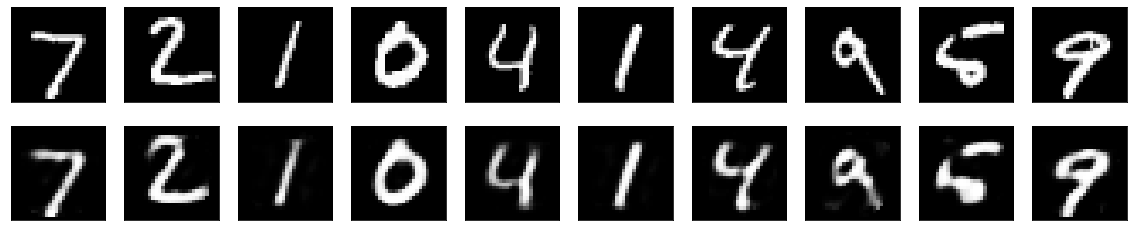

In [9]:
# First we create the encoding of test images, and then reconstruct it
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Plot some of these
num_plot = 10
plt.figure(figsize = (20, 4))
for i in range(num_plot):
    # original
    ax = plt.subplot(2, num_plot, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, num_plot, i + 1 + num_plot)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Hooray! It's not perfect, but it's pretty close. This shows that the autoencoder compression is not lossless. We could try deepening the network by adding more layers to the encoder and decoder and the recreated images might be more accurate.

One question is - what's in the encoded/latent space? What is it doing? In essence, the hidden layer is learning an approximation of principal component analysis. Pretty cool that we trained a neural network to learn a deterministic method on its own!

Let's try to visualize the encoding space. We can use t-SNE, a popular nonlinear dimensionality reduction method, to project the 32-dimensional space into 2 dimensions so we can visualize it.

#### Encoding space visualization

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Initialize t-SNE and PCA
tsne = TSNE(n_components = 2, random_state = 0, verbose = 1)
pca = PCA(n_components = latent_dim)
# Apply tSNE to encoded representation
tsne_coords = tsne.fit_transform(encoded_imgs)
# Apply PCA to original img  and then tSNE to compare
pca_latent = pca.fit_transform(x_test)
tsne_pca = tsne.fit_transform(pca_latent)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.046s...
[t-SNE] Computed neighbors for 10000 samples in 8.460s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.889087
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.380997
[t-SNE] KL divergence after 1000 iterations: 1.808776
[t-SNE] Computing 91 near

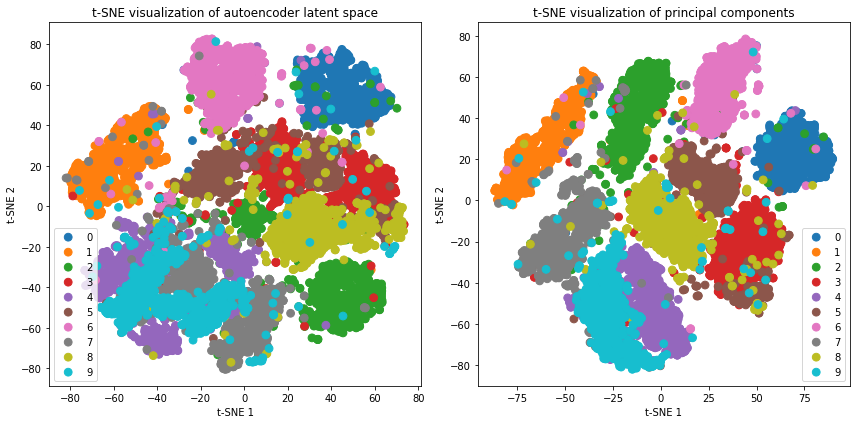

In [21]:
# One figure to plot all the images
fig,ax = plt.subplots(1, 2, figsize = (12,6))
# Get a colormap to map each digit to a color
colors = plt.cm.tab10(np.linspace(0,1,10))

# Scatter plot
for digit in np.unique(y_test):
    idx = np.where(y_test == digit)
    ax[0].scatter(tsne_coords[idx,0], tsne_coords[idx,1], s = 60, c = colors[y_test[idx]])
    ax[1].scatter(tsne_pca[idx,0], tsne_pca[idx,1], s = 60, c = colors[y_test[idx]])

ax[0].set_xlabel('t-SNE 1')
ax[0].set_ylabel('t-SNE 2')
ax[0].set_title('t-SNE visualization of autoencoder hidden layer')
ax[0].legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax[1].set_xlabel('t-SNE 1')
ax[1].set_ylabel('t-SNE 2')
ax[1].set_title('t-SNE visualization of principal components')
ax[1].legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
fig.tight_layout()
plt.show()

Now we can see that the autoencoder is learning some projection of the data that allows it to distinctly recreate each digit. The PCA representation is very similar, demonstrating the dimensionality reduction and clustering potential of the autoencoder. Interestingly, PCA seems a bit cleaner. Perhaps for a simplistic dataset such as MNIST PCA works fine, but for more complicated images we will need to leverage the nonlinearities in the autoencoder. 

## Convolutional autoencoders

Convolutional neural networks utilize 2D filters with trainable weights that are scanned horizontally and vertically across and image to understand spatial patterns. The details of CNNs are outside the scope of this notebook, but these types of neural networks are widely used for object identification in images. We can outfit the encoder and decoder with convolutional neural networks instead of simple full connected layers to gain the advantage of learning spatial relationships. In fact, autoencoders applied to images are almost always convolutional autoencoders because they just work better.

#### Construct model

In [27]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape = (28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


To be honest, the reasoning for the filter sizes and number of filters in each convolutional layer is beyond my understanding. This is from the Keras tutorial on autoencoders. I'd imagine these standard rule of thumb numbers for a basic CNN. And of course for the decoder you may want to mirror the structure of the encoder. The number of filters should slowly decrease as we encode and slowly increase as we decode. Maxpooling serves as downsampling, upsampling is upsampling. Also, seems like AdaDelta and binary cross entropy loss are preferred for autoencoders. Not entirely sure why. It didn't work with Adam and MSE loss.

#### Prep data

In [28]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#### Train model

This will take much longer than a multilayer perceptron architecture like above. The network is deeper and convolution layers require a higher number of math operations.

In [29]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 57s 954us/step - loss: 0.2107 - val_loss: 0.1630
Epoch 2/50
60000/60000 [==============================] - 58s 974us/step - loss: 0.1555 - val_loss: 0.1458
Epoch 3/50
60000/60000 [==============================] - 59s 976us/step - loss: 0.1427 - val_loss: 0.1348
Epoch 4/50
60000/60000 [==============================] - 57s 950us/step - loss: 0.1356 - val_loss: 0.1337
Epoch 5/50
60000/60000 [==============================] - 57s 954us/step - loss: 0.1302 - val_loss: 0.1236
Epoch 6/50
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1259 - val_loss: 0.1226
Epoch 7/50
60000/60000 [==============================] - 57s 943us/step - loss: 0.1230 - val_loss: 0.1187
Epoch 8/50
60000/60000 [==============================] - 57s 946us/step - loss: 0.1205 - val_loss: 0.1185
Epoch 9/50
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1186 - val_loss

#### Image reconstruction

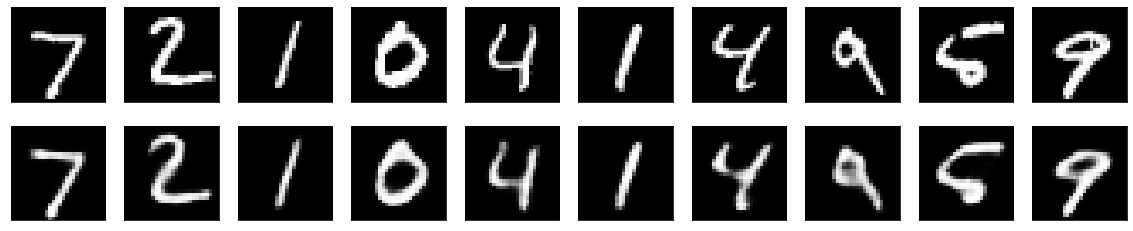

In [30]:
decoded_imgs = autoencoder.predict(x_test)

# Plot some of these
num_plot = 10
plt.figure(figsize = (20, 4))
for i in range(num_plot):
    # original
    ax = plt.subplot(2, num_plot, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, num_plot, i + 1 + num_plot)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Not bad at all! Though pretty comparable to the simple architecture. Of course with real RGB images the convolutional form will have clear advantages.

## Variational autoencoders

Simple autoencoders work as a mapping of the input to a lower-dimensional space that retain all the informative features necessary to reconstruct the input. In a sense, it works as a glorified dimensionality reduction method. But there is more potential for the encoded space in the hidden layer. But what if we want to generate images similar to our training data, instead of being able to replicate it? What if our observed high-dimensional image data is actually the result of sampling from lower-dimensional underlying variables? What are the true hidden, or latent, variables that are generating the data we are observing? Can we use this to generate similar data?

Variational autoencoders learn parameters to map the input to the distribution of the random variables in the latent space. For example, say there are three hidden variables for our high-dimensional dataset. Each of these variables may have a prior, or an inferred type of probability distribution, such as a normal distribution, which is associated with a mean and variance term. Thus, the VAE learns the weights that map input activations to these means and sigmas. Then, we can generate data using the decoder by sampling from the latent space, because we have approximated the distribution underlying the observed data. Thus, VAEs are generative models.

![](vae.png)

To learn this distribution, we must add another term to our loss function: the KL divergence of the estimated distribution from the target distribution, which is usually a standard normal distribution. This will force the learned parameters to map to a normal distribution centered around a mean of zero with a variance of 1, while the reconstruction loss tends to cluster similar inputs.

![](latent_space.png)

VAEs are more applicable than normal autoencoders, as they can be used to generate missing data or denoise datasets or even apply slight transformations or modifications to the dataset.

#### Prep data

In [45]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
K.clear_session()

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

#### Construct model

We need to create a function that allows us to sample from the latent space from the computed mean and variance values.

In [2]:
def sampling(args):
    mu, sigma = args
    batch_size = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape = (batch_size, dim))
    return mu + K.exp(sigma * 0.5) * eps

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

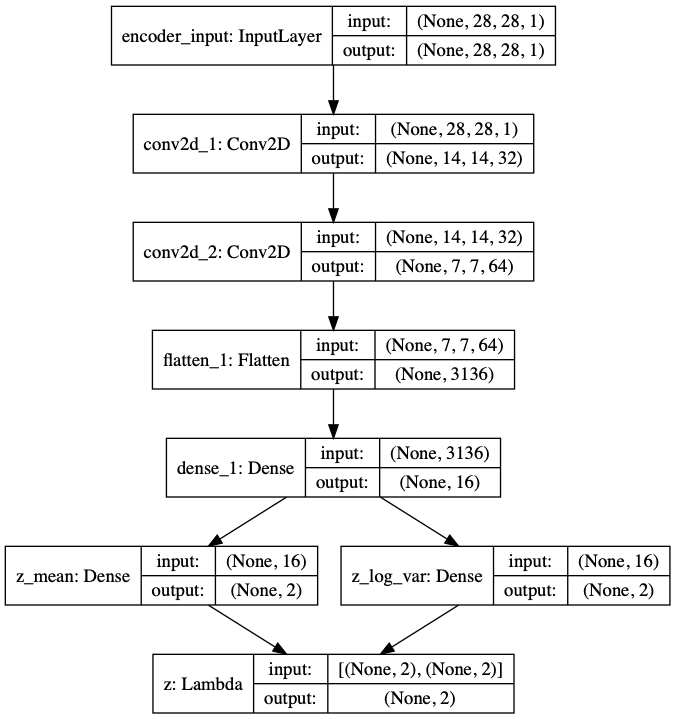

In [49]:
# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

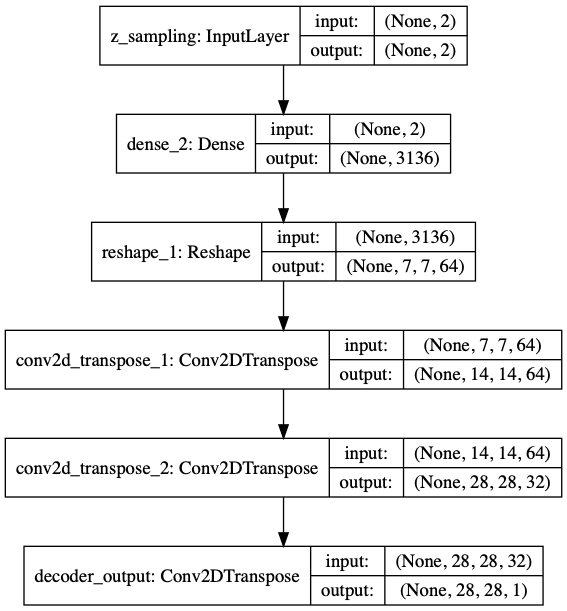

In [50]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

In [51]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Loss function
def kl_reconstruction_loss(true, pred):
    recon_loss = binary_crossentropy(K.flatten(true), K.flatten(pred))
    recon_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis = -1)
    kl_loss *= -0.5
    return K.mean(recon_loss + kl_loss)

#### Train model

In [7]:
vae.compile(optimizer = 'rmsprop', loss = kl_reconstruction_loss)
vae.fit(x_train, x_train,
        epochs = epochs,
        batch_size = batch_size,
        validation_data = (x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 61s 1ms/step - loss: 200.7682 - val_loss: 176.5223
Epoch 2/30
60000/60000 [==============================] - 72s 1ms/step - loss: 171.5244 - val_loss: 166.9586
Epoch 3/30
60000/60000 [==============================] - 61s 1ms/step - loss: 165.6948 - val_loss: 164.2309
Epoch 4/30
60000/60000 [==============================] - 70s 1ms/step - loss: 162.2989 - val_loss: 162.5910
Epoch 5/30
60000/60000 [==============================] - 61s 1ms/step - loss: 160.1842 - val_loss: 158.7548
Epoch 6/30
60000/60000 [==============================] - 59s 977us/step - loss: 158.6430 - val_loss: 158.3062
Epoch 7/30
60000/60000 [==============================] - 103s 2ms/step - loss: 157.3200 - val_loss: 156.6252
Epoch 8/30
60000/60000 [==============================] - 59s 982us/step - loss: 156.2836 - val_loss: 155.2630
Epoch 9/30
60000/60000 [==============================] - 58s 968us/step 

#### Visualization

In [12]:
import os

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap = 'tab10')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

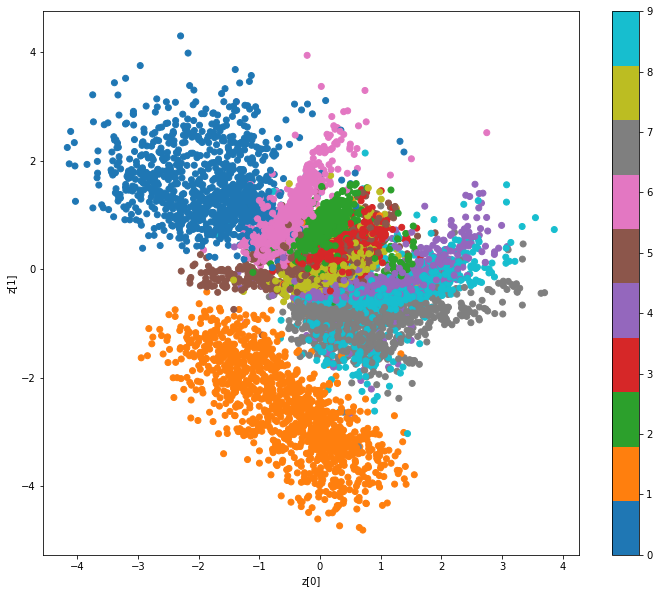

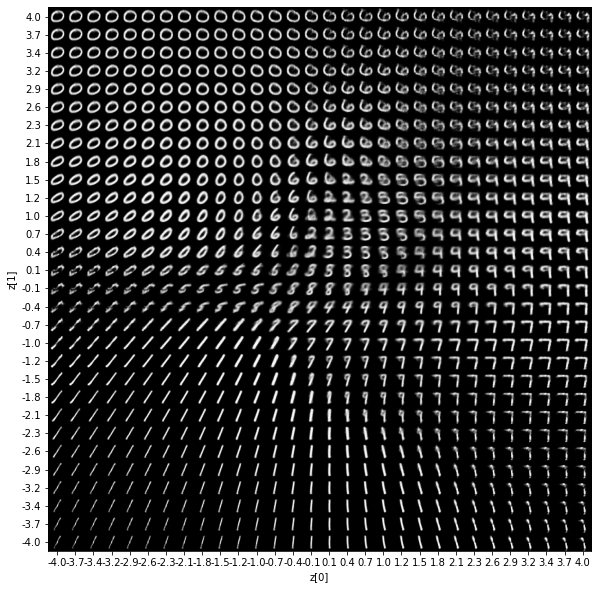

In [13]:
# Plot results
models = (encoder, decoder)
data = (x_test, y_test)
plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

We see that the network is able to learn distinct 2D latent representations for many of the digits, though some digits overlap a lot more and are more difficult to produce. Looks like one dimension changes the angle of a vertical line and the second dimension introduces the hole topology. Naturally, many of the numbers have both features and lie in the middle. 

### Denoising and missing data completion

Let's test the generative power of the model by training it to reproduce the cleaned version of a handwritten digits when it's fed noisy images or images with missing data. The training procedure is slightly different in this case; we will use the corrupted image as the input and the clean image as the output. This forces the network to learn a robust representation of the data with limited information.

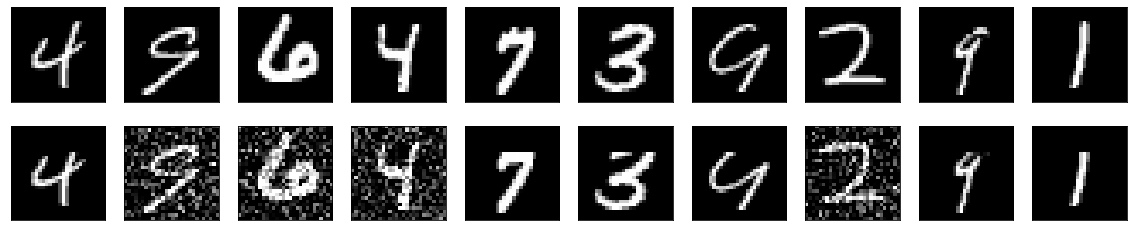

In [47]:
from skimage.util import random_noise

def corrupt_image(img, noise_var = 0.05, cutoff_percent = 0.25):
    """
    Randomly add noise or remove the top few lines of an image
    
    Inputs:
    img - numpy array of shape (height, width, 1)
    """
    img_array = np.array(img)
    img_array = np.reshape(img_array, (img.shape[0], img.shape[1]))
    # Randomly decide whether to add noise or crop
    noise_or_cut = np.random.choice([0,1], size=1)
    # Add noise
    if noise_or_cut == 0:
        corrupt_img = random_noise(img_array, mode = 'gaussian', clip = True, var = noise_var)
    elif noise_or_cut == 1:
        corrupt_img = img_array
        num_lines_cut = int(img_array.shape[0] * cutoff_percent)
        corrupt_img[:num_lines_cut] = 0
    
    corrupt_img = np.reshape(corrupt_img, (corrupt_img.shape[0], corrupt_img.shape[1], 1))
    
    return corrupt_img


# Test the function
num_plot = 10
idx = np.random.choice(x_train.shape[0], num_plot)
corrupt_examples = [corrupt_image(img, noise_var = 0.1, cutoff_percent = 0.3) for img in x_train[idx]]

plt.close('all')
plt.figure(figsize = (20, 4))
for i in range(num_plot):
    # original
    ax = plt.subplot(2, num_plot, i + 1)
    plt.imshow(x_train[idx][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, num_plot, i + 1 + num_plot)
    plt.imshow(corrupt_examples[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Run for all images
x_train_corrupt = np.array([corrupt_image(img, noise_var = 0.1, cutoff_percent = 0.3) for img in x_train])
x_test_corrupt = np.array([corrupt_image(img, noise_var = 0.1, cutoff_percent = 0.3) for img in x_test])

#### Recreate model

In [55]:
# Delete existing model and clear session
K.clear_session()

# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

#### Train model with corrupted inputs

In [56]:
vae.compile(optimizer = 'rmsprop', loss = kl_reconstruction_loss)
vae.fit(x_train_corrupt, x_train,
        epochs = 50,
        batch_size = batch_size,
        validation_data = (x_test_corrupt, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 82s 1ms/step - loss: 200.3423 - val_loss: 172.9855
Epoch 2/50
60000/60000 [==============================] - 62s 1ms/step - loss: 169.3869 - val_loss: 167.6860
Epoch 3/50
60000/60000 [==============================] - 70s 1ms/step - loss: 164.5095 - val_loss: 162.6734
Epoch 4/50
60000/60000 [==============================] - 69s 1ms/step - loss: 161.7410 - val_loss: 161.0787
Epoch 5/50
60000/60000 [==============================] - 63s 1ms/step - loss: 159.7781 - val_loss: 158.6212
Epoch 6/50
60000/60000 [==============================] - 68s 1ms/step - loss: 158.1847 - val_loss: 158.1759
Epoch 7/50
60000/60000 [==============================] - 76s 1ms/step - loss: 156.9324 - val_loss: 157.1369
Epoch 8/50
60000/60000 [==============================] - 63s 1ms/step - loss: 155.9458 - val_loss: 155.9130
Epoch 9/50
60000/60000 [==============================] - 94s 2ms/step - loss:

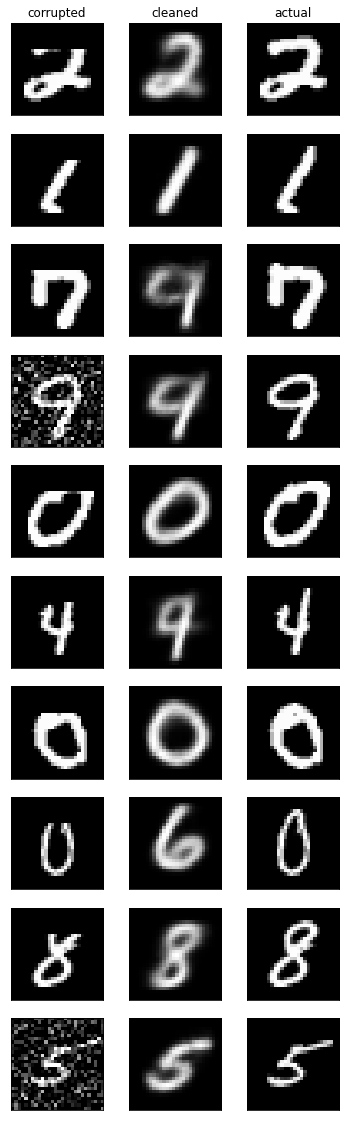

In [62]:
num_plot = 10
idx = np.random.choice(x_test_corrupt.shape[0], num_plot)
cleaned_imgs = vae.predict(x_test_corrupt[idx])

plt.close('all')
plt.figure(figsize = (6, 20))
for i in range(num_plot):
    row = 3 * i + 1
    # corrupted
    ax = plt.subplot(num_plot, 3, row)
    plt.imshow(x_test_corrupt[idx][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('corrupted')

    # cleaned
    ax = plt.subplot(num_plot, 3, row + 1)
    plt.imshow(cleaned_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('cleaned')
    
    # actual
    ax = plt.subplot(num_plot, 3, row + 2)
    plt.imshow(x_test[idx][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('actual')
    
plt.show()

Seems like it worked moderately well. Some inputs gave the model a challenge, despite having little corruption, such as the 7 somehow turning into a 9. Since there were two artifacts I introduced, it probably had difficulty dealing with both simultaneously. the noisy inputs likely muddied each digit's latent representation and created less distinct clusters, which is why it has an easy time with digits that have more distinguished clusters (0,1,9, see plots above) and not with digits that are more similar (7 and 9, 9 and 4). Ways to address this could be to make the architecture deeper - it is possible that the model is underfitting. It might be interesting to throw in an adversarial classifier to help boost the generation capability.